# Chess Challenge

Welcome to the chess challenge of the MQST Qiskit Fall Fest!

The queens puzzle is the problem of placing the maximum number of chess queens on an $N \times N$ chessboard such that no two queens threaten each other. It is often used as an example in various computational techniques. This problem does not have a unique solution, and the complexity of finding one increases exponentially with the size of $N$.

#### First install the necessary packages:

In [1]:
# Uncomment to install the necessary packages

%pip install --upgrade pip
%pip install numpy==2.3.4
%pip install scipy==1.16.2
%pip install matplotlib==3.10.7
%pip install jupyter
%pip install qiskit[visualization]==2.2
# # For Local Linux or Mac, you can use the following command:
# # %pip install 'qiskit[visualization]'
%pip install qiskit_algorithms==0.4.0
%pip install qiskit_aer==0.17.2
%pip install qiskit_ibm_runtime==0.41.1
%pip install qiskit_ibm_transpiler==0.14.3

Note: you may need to restart the kernel to use updated packages.
ERROR: Ignored the following versions that require a different python version: 2.3.0 Requires-Python >=3.11; 2.3.1 Requires-Python >=3.11; 2.3.2 Requires-Python >=3.11; 2.3.3 Requires-Python >=3.11; 2.3.4 Requires-Python >=3.11
ERROR: Could not find a version that satisfies the requirement numpy==2.3.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6, 1

In [2]:
# Import all necessary libraries
import numpy as np
import scipy
from qiskit.circuit.library import QAOAAnsatz
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
backend = AerSimulator(method="statevector")

# 1- Starting from the basics: before queens there were rooks

To start slowly, we will solve the problem for rooks, for which is much easier to find a solution but has the disadvantage that there are many more solutions. What is the max number of rooks that can fit in a 4x4 chess board? And on a 5x5?

## The first task is to create a classical function that by brute force gives the solutions for the rooks puzzle for NxN chess board.

> Tip: Represent the chess board by an NxN array filled with 0 for the empty squares and by 1 for the squares in which a rook is placed. This representation will also help you during great part of this challenge

In [3]:
def classical_rooks(N):
    sols = []

    def backtrack(row, used_cols, board):
        # Caso base: si hemos colocado todas las torres
        if row == N:
            sols.append(np.copy(board))
            return

        # Intentar colocar una torre en cada columna libre
        for col in range(N):
            if col not in used_cols:
                board[row, col] = 1
                backtrack(row + 1, used_cols | {col}, board)
                board[row, col] = 0  # deshacer paso

    initial_board = np.zeros((N, N), dtype=int)
    backtrack(0, set(), initial_board)

    return np.array(sols)


# Ejemplo de uso:
N = 3
sols = classical_rooks(N)
print(f"Se encontraron {len(sols)} soluciones para {N} torres.")
for s in sols:  # Mostrar las tres primeras
    print(s)
    print()

Se encontraron 6 soluciones para 3 torres.
[[1 0 0]
 [0 1 0]
 [0 0 1]]

[[1 0 0]
 [0 0 1]
 [0 1 0]]

[[0 1 0]
 [1 0 0]
 [0 0 1]]

[[0 1 0]
 [0 0 1]
 [1 0 0]]

[[0 0 1]
 [1 0 0]
 [0 1 0]]

[[0 0 1]
 [0 1 0]
 [1 0 0]]



Computing the available solutions by brute force is expensive and untractable when dealing with bigger boards, so we will take advantaje of the hybrid algorithm QAOA to solve this problem in a different way, phrasing the problem as a physics optimization problem, namely finding the state with lowest energy for a given hamiltonian.

The general form of a optimization problem can be written on the form of a hamiltonian:

$$H_C = \sum_{i,j} Q_{ij} X_i X_j + \sum_i b_i X_i$$

where $X_i$ are classical variables can be 1 or 0 and the coefficients $b_i$ and $Q_{ij}$ are problem dependent.

To find a solution using qubits, first we need to map the qubits form a quantum circuit to represent our problem. For that, one suggestion is to use the following mapping:
- Each qubit will represent one square of the chess board, so it will be identified by row and column indices.
- If there is a piece on that square, the spin will be on state $|1>$, and if it is empty the state will be $|0>$

<p style="text-align: center"><img src="https://i.imgur.com/ojkY5to.jpeg"></p>


> Example 3x3 board:
- q0 in state 0 -> 0,0
- q1 in state 0 -> 0,1
- q2 in state 0 -> 0,2
- q3 in state 0 -> 1,0
- q4 in state 0 -> 1,1
- q5 in state 1 -> 1,2
- q6 in state 0 -> 2,0
- q7 in state 0 -> 2,1
- q8 in state 0 -> 2,2

This is just a suitable mapping but it is not unique. There are many more mappings that can be used for this problem, so if you have any other please explain it and use it!!!

For the previous mapping we need $N^2$ qubits to find a solution for a NxN chess board, so a way to improve this mapping could be to reduce the number of qubits needed to map the problem. A new mapping will also change some of the following instructions... be carefull with that!!

To adapt the expression to our problem, we will change the single index $i$ of the classical variables to the actual chess board indices, where latin letters will be rows and greek indices will be columns. Therefore, the classical hamiltonian for our mapping is of the form:

$$H_C = \sum_{k,\alpha ,l,\beta} Q_{k \alpha,l \beta} X_{k\alpha}X_{l\beta} + \sum_{k\alpha} b_{k\alpha} X_{k\alpha}$$

Moreover, we need to define a specific hamiltonian whose groundstate is a solution of the rooks puzzle. For that, we will need two terms:
- One term that lowers the energy with the number of rooks ($|1>$ states)
> Tip: this is a one-body term
- One term that increases the energy if one rook threatens other. This penalization should be bigger than the energy gained by adding one other rook
> Tip: this is a two body interaction term

 Define the weigths $b_{k\alpha}$ and $Q_{k\alpha, l\beta}$ such that the previous cost function has as ground state the solution of the rook's puzzle. Make the cost of threatening 1.5 times the benefit of adding one extra rook (one extra $X$ with 1 value)

> Tip: Adding one more rook DECREASES energy, therefore $b<0$, and having threatened rooks should INCREASE it, therefore $Q>0$. Use $b=-1$ and $Q=1.5$ for those cases where the value is non-zero.

> Tip2: The rooks in chess only move vertical and horizontal, so the only relevant $Q$ coefficients are those for which $k=l$ or $\alpha=\beta$.

In [4]:
def classical_hamiltonian_rook_onebody_coeff(N: int) -> np.ndarray:
    """Returns the NxN matrix of b_{k \alpha} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        b_vector (np.array): The NxN matrix of b_{k \alpha} weigths.
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.

    """
    # Your code here
    b_vector = np.full((N, N), -1)
    return b_vector


def classical_hamiltonian_rooks_twobody_coeff(N: int) -> np.ndarray:
    """Returns the NxNxNxN array of Q_{k \alpha, l \beta} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        Q_matrix (np.array): The NxNxNxN array of Q_{k \alpha, l \beta} weigths.
    """

    # Your code here
    Q_matrix = np.zeros((N, N, N, N), dtype=float)
    # Assign weights for positions sharing a row or column (but not identical)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    if ((i == k) or (j == l)) and not ((i == k) and (j == l)):
                        Q_matrix[i, j, k, l] = 1.5
    return Q_matrix


def classical_hamiltonian_rooks(N: int, X_string: np.ndarray) -> float:
    """Returns the value of the hamiltonian for a given X_matrix of length NxN.

    Args:
        N (int): The dimension of the chess board.
        Z_matrix (np.array): The NxN matrix of X_{k \alpha} values.


    Returns:
        energy (float): The value of the hamiltonian for the given Z_matrix.
    """
    # Your code here
    b = classical_hamiltonian_rook_onebody_coeff(N)
    Q = classical_hamiltonian_rooks_twobody_coeff(N)

    # Getting the tensor of X to calculate energy faster
    Xtensor = np.tensordot(X_string, X_string, axes=0)
    energy = np.sum(b*X_string) + np.sum(Xtensor*Q)/2
    return energy


X_string1 = np.array([[1, 1, 1], [0, 0, 0], [1, 1, 1]])
X_string2 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

print("Not efficient positioning:\n", X_string1, "Energy:", classical_hamiltonian_rooks(3, X_string1))
print()
print("Efficient positioning:\n", X_string2, "Energy:", classical_hamiltonian_rooks(3, X_string2))

Not efficient positioning:
 [[1 1 1]
 [0 0 0]
 [1 1 1]] Energy: 7.5

Efficient positioning:
 [[1 0 0]
 [0 1 0]
 [0 0 1]] Energy: -3.0


As our system is a quantum system where the hamiltonian is an operator, whe should write it in terms of known operators. For that, we will do the change of variable
$$X_{k\alpha} = \frac{1-\hat\sigma^z_{k\alpha}}{2}$$
where $\hat \sigma^z_{k\alpha}$ is the Pauli Z operator acting on the qubit that represents the square of row $k$ and column $\alpha$. Introducing this change of variable on the previous function, you will obtain a quantum operator of the same form with an extra constant term that can be neglected because it only changes the origin of the energy.

> Hint: For this step you might need some pen and paper calculations to find the transformation!

## Write the new hamiltonian and create the associated functions to find the new coefficients

__Write here your hamiltonian__

In [5]:
def quantum_hamiltonian_rook_onebody_coeff(N):
    """Returns the NxN matrix of b_{k \alpha} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        b_vector (np.array): The NxN matrix of b_{k \alpha} weigths.
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
    """
    # Your code here
    b_vector = np.full((N,N), -1.5)
    return b_vector


def quantum_hamiltonian_rooks_twobody_coeff(N):
    """Returns the NxNxNxN array of Q_{k \alpha, l \beta} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        Q_matrix (np.array): The NxNxNxN array of Q_{k \alpha, l \beta} weigths.
    """
    # Your code here
    Q_matrix = np.full((N,N,N,N), 1.5)
    return Q_matrix

Now, we are able construct the hamiltonian for our problem, using the previous coefficients to create a quantum operator.

## Write a function that creates the hamiltonian of the rooks puzzle as a SparsePauliOp
> Tip: Use the previous functions to obtain the coefficients of the hamiltonian

In [6]:
def cost_hamiltonian_rooks(N):
    """Returns the Hamiltonian of the rooks puzzle as a SparsePauliOp."""

    # Get one-body and two-body coefficients
    b_vector = quantum_hamiltonian_rook_onebody_coeff(N)
    Q_matrix = quantum_hamiltonian_rooks_twobody_coeff(N)

    # Initialize Hamiltonian components
    one_body = 0.
    two_body = 0.

    # Identity string representing all qubits
    id_og = (N * N) * "I"

    # Helper function: insert a 'Z' at board position (i, j)
    def pauli_string(N, i, j, string):
        s_list = list(string)
        s_list[i * N + j] = 'Z'
        return ''.join(s_list)

    # Loop over all board positions (k, α)
    for k in range(N):
        id = str(np.copy(id_og))
        for alpha in range(N):

            # One-body term: single-qubit contribution
            id_one_body = pauli_string(N, k, alpha, id)
            pauli_one_body = SparsePauliOp(id_one_body)
            one_body += -0.5 * b_vector[k, alpha] * pauli_one_body

            # Two-body terms: interactions between positions (k, α) and (l, β)
            for l in range(N):
                for beta in range(N):
                    # Only penalize if they share row or column but aren’t identical
                    if (k == l or alpha == beta) and not (k == l and alpha == beta):
                        id_other_index = pauli_string(N, l, beta, id)
                        id_two_body = pauli_string(N, l, beta, id_one_body)

                        # Build combined Pauli operator for this interaction
                        pauli_final = SparsePauliOp.from_list([
                            (id_two_body, 1),
                            (id_other_index, -1),
                            (id_one_body, -1)
                        ])

                        # Add weighted interaction to Hamiltonian
                        two_body += 0.5 * 0.25 * Q_matrix[k, alpha, l, beta] * pauli_final

    # Combine one-body and two-body terms
    hamiltonian = two_body + one_body
    return hamiltonian

# 1.1 Finding solutions for the rook puzzle

Now that we have constructed the hamiltonian that encodes the solution of the problem, we just need to find the groundstate of it.
For that we will use the QAOA algorithm, where the circuit is optimized to find a groundstate of the cost function.

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal parameters.
Check [QAOAAnsatz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.QAOAAnsatz), and using scipy [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function run the QAOA algorithm to find the solution of the rooks puzzle, using only two layers.

> Note: There is an [example at IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) but it contains the way to run the algorithm on real hardware which up to now it is not the goal. **Check it to get inspiration but run this optimization locally using AerSimulator** or any other simulated backend.

> Note 2: The solution might not be unique


In [14]:
def QAOA_rooks(N, p=2):
    # Build cost Hamiltonian for N-rooks
    H = cost_hamiltonian_rooks(N)

    # Estimator and transpilation pass manager
    estimator = Estimator()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

    # Create QAOA ansatz and apply layout
    var_state = pm.run(QAOAAnsatz(cost_operator=H, reps=p))
    isa_observable = H.apply_layout(var_state.layout)

    # Cost function: expectation value of H
    def cost_func_estimator(params, var_state, hamiltonian):
        job = estimator.run([(var_state, hamiltonian, params)])
        result = job.result()
        exp_val = result[0].data.evs
        return np.real(exp_val)

    # Random parameter initialization
    init_params = np.random.uniform(0, 2*np.pi, 4)

    # Classical optimization (COBYLA)
    res = minimize(
        cost_func_estimator,
        init_params,
        args=(var_state, H),
        method="COBYLA",
        tol=1e-8,
    )

    print("Energía mínima encontrada:", res.fun)
    print("Parámetros óptimos:", res.x)

    # Assign optimal parameters to circuit
    opt_circuit = var_state.assign_parameters(res.x)
    return opt_circuit, res.x, init_params


def process_results(N, opt_circuit, n_bars=10, n_probs=500, n_shots=1e6):
    # Initialize sampler backend
    sampler = SamplerV2()

    print("Getting probs...")
    opt_circuit.measure_all()

    # Execute circuit and collect measurement results
    pub = (opt_circuit,)
    job = sampler.run([pub], shots=int(n_shots))
    result = job.result()[0]
    counts_bin = result.data.meas.get_counts()

    # Prepare data for visualization
    ord_labs, ord_res = [], []
    print("Readying probs for graph...")
    for bitstring, p in sorted(counts_bin.items(), key=lambda x: -x[1])[:n_probs]:
        n_bitstring = [bitstring[N*i:N*(i+1)] + "\n" for i in range(N)]
        ord_labs.append("".join(n_bitstring)[:-1])
        ord_res.append(p)

    # Plot most probable bitstrings
    print("Making graph...")
    fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
    ax.bar(ord_labs[:n_bars], ord_res[:n_bars], color="blue")
    ax.set_ylabel("Shots Result")
    ax.set_xlabel("Qubit states")
    ax.set_title(f"Most probable states for Rook Problem on N={N}")
    plt.show()
    return

## Run the QAOA algorithm for 3x3 and 4x4 boards and discuss the solutions obtained.
## Compare the solutions with the ones obtained by brute force.

Energía mínima encontrada: -2.737849760728284
Parámetros óptimos: [1.57382416 3.54394067 6.24488798 1.64383646]
Getting probs...
Readying probs for graph...
Making graph...


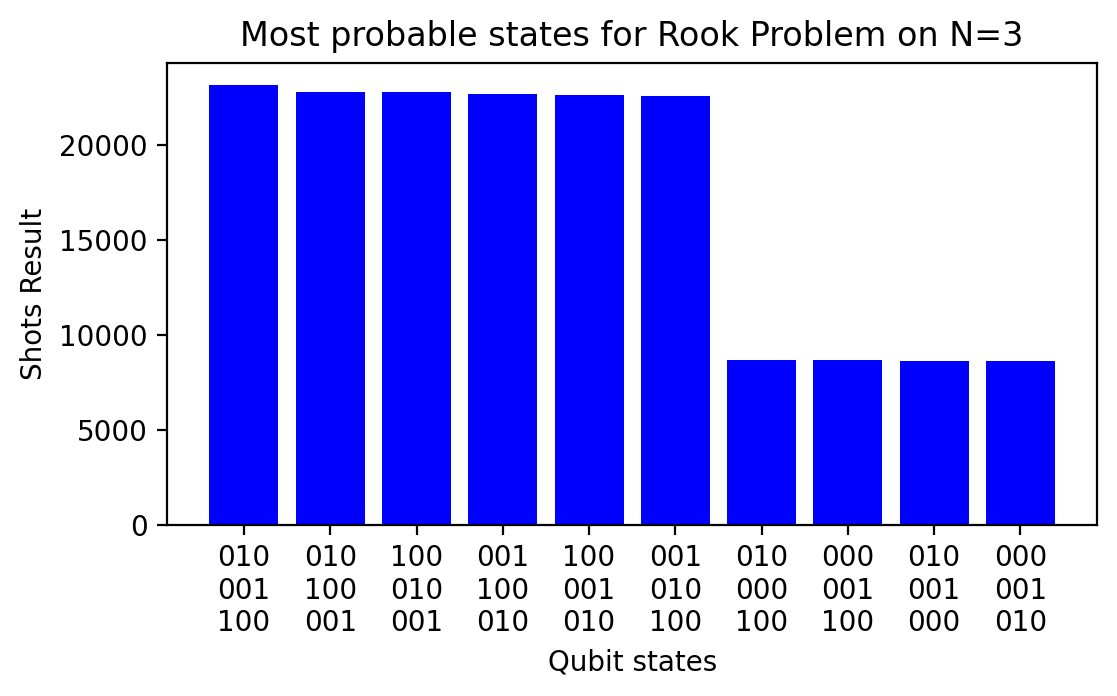

In [15]:
# 3x3 case
opt_circuit, res, init_params = QAOA_rooks(3)
process_results(3, opt_circuit)

Energía mínima encontrada: -7.179393937058639
Parámetros óptimos: [6.79708715 1.40491241 4.75382968 1.54108152]
Getting probs...
Readying probs for graph...
Making graph...


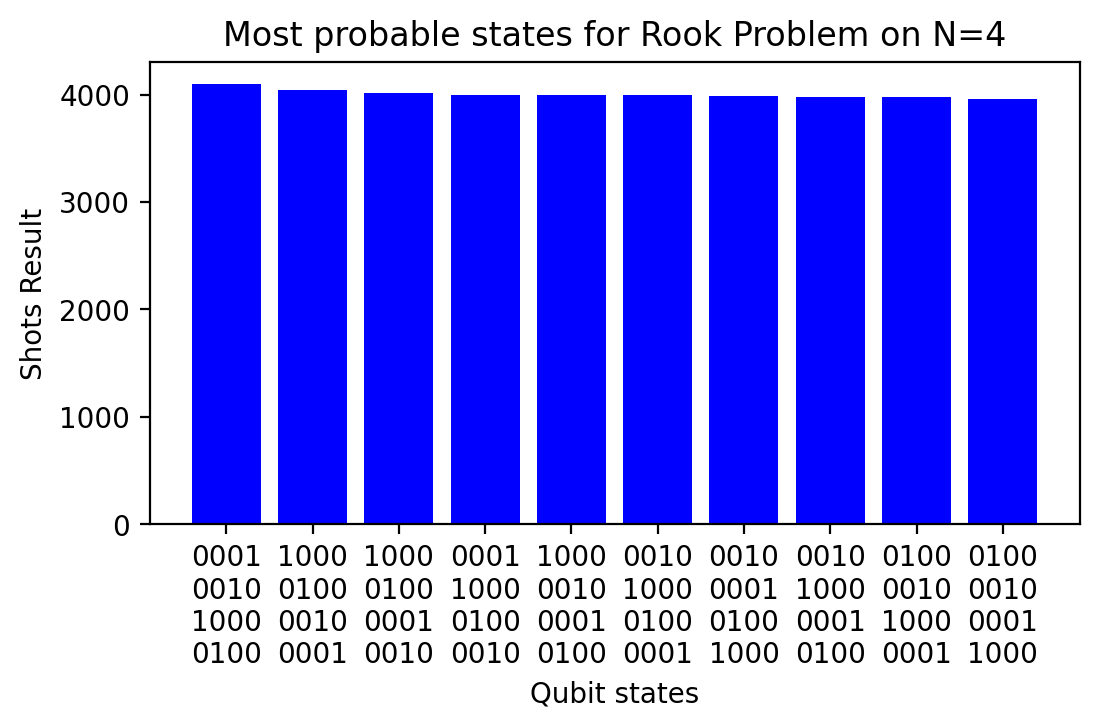

In [16]:
# 4x4 case
opt_circuit, res, init_params = QAOA_rooks(4)
process_results(4, opt_circuit)

# 1.2 Finding a specific solution for the rook puzzle

As you might have seen before, the solution obtained using the previous hamiltonian is usually a superposition of all possible configurations of rooks on the board. To obtain a single solution, we must break the degeneracy of the solution by unbalancing the positions in which the rooks appear.

One of the simplest ways to do this is "tilting" the chess board, i.e., favoring the positioning of the rooks on one side of the board. To do this, one can add a small bias on the single-body terms of the form:

- $b_{00}$ <- $b_{00}$
- $b_{01}$ <- $b_{01}$ + $\delta$
- $b_{02}$ <- $b_{02}$ + $\sqrt{2}\delta$
- ...
- $b_{NN}$ <- $b_{NN}$ + $N\delta$

where $\delta$ should be small compared with the value of $b$ and $Q$, but not infinitely small. You might optimize this by comparing some solutions for different values of $\delta$, or maybe use your creativity to break the degeneracy using different weights and method.

## Introduce the modification on the one-body terms and run again all the steps of the algorithm to find a solution of the rook puzzle. What is the accuracy for the algorithm to find the solution?

> Extra: Can you implement this bias also for the brute force search?

In [17]:
def quantum_hamiltonian_rook_onebody_coeff(N):
    """Returns the NxN matrix of b_{kα} weights."""
    # Uniform one-body weights (-1.5 for each rook position)
    b_vector = np.full((N, N), -1.5)
    return b_vector


def cost_hamiltonian_rooks_no_deg(N):
    """Returns the non-degenerate Hamiltonian of the rooks puzzle as a SparsePauliOp."""

    # Get one-body and two-body coefficient matrices
    b_vector = quantum_hamiltonian_rook_onebody_coeff(N)
    Q_matrix = quantum_hamiltonian_rooks_twobody_coeff(N)

    # Initialize Hamiltonian components
    one_body = 0.
    two_body = 0.
    id_og = (N * N) * "I"

    # Small perturbation term to remove energy degeneracy
    delta = 0.25

    # Helper: create Pauli string with 'Z' at position (i, j)
    def pauli_string(N, i, j, string):
        s_list = list(string)
        s_list[i * N + j] = 'Z'
        return ''.join(s_list)

    # Construct Hamiltonian
    for k in range(N):
        id = str(np.copy(id_og))
        for alpha in range(N):
            # One-body term with non-degenerate correction
            id_one_body = pauli_string(N, k, alpha, id)
            pauli_one_body = SparsePauliOp(id_one_body)

            if k == 0:
                coeff = b_vector[k, alpha] - np.sqrt(alpha) * delta
            elif alpha == 0:
                coeff = b_vector[k, alpha] - np.sqrt(k) * delta
            else:
                coeff = b_vector[k, alpha] - np.sqrt(k) * np.sqrt(alpha) * delta

            one_body += -0.5 * coeff * pauli_one_body

            # Two-body interaction terms
            for l in range(N):
                for beta in range(N):
                    # Penalize if two rooks share row or column
                    if (k == l or alpha == beta) and not (k == l and alpha == beta):
                        id_other_index = pauli_string(N, l, beta, id)
                        id_two_body = pauli_string(N, l, beta, id_one_body)

                        pauli_final = SparsePauliOp.from_list([
                            (id_two_body, 1),
                            (id_other_index, -1),
                            (id_one_body, -1)
                        ])

                        two_body += 0.5 * 0.25 * Q_matrix[k, alpha, l, beta] * pauli_final

    # Combine one- and two-body components
    hamiltonian = two_body + one_body
    return hamiltonian

In [22]:
def QAOA_rooks(N, p=2):
    """Runs QAOA optimization for the N-Rooks problem."""

    # Build cost Hamiltonian
    H = cost_hamiltonian_rooks(N)

    # Initialize estimator and pass manager
    estimator = Estimator()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

    # Create QAOA ansatz circuit and apply layout
    var_state = pm.run(QAOAAnsatz(cost_operator=H, reps=p))
    isa_observable = H.apply_layout(var_state.layout)

    # Cost function: expectation value of the Hamiltonian
    def cost_func_estimator(params, var_state, hamiltonian):
        job = estimator.run([(var_state, hamiltonian, params)])
        result = job.result()
        exp_val = result[0].data.evs
        return np.real(exp_val)

    # Random initial parameters
    init_params = np.random.uniform(0, 2*np.pi, 4)

    # Classical optimization using COBYLA
    res = minimize(
        cost_func_estimator,
        init_params,
        args=(var_state, H),
        method="COBYLA",
        tol=1e-8,
    )

    # Report optimization results
    print("Energía mínima encontrada:", res.fun)
    print("Parámetros óptimos:", res.x)

    # Construct optimized circuit
    opt_circuit = var_state.assign_parameters(res.x)
    return opt_circuit, res.x, init_params


def process_results(N, opt_circuit, n_bars=10, n_probs=500, n_shots=1e6):
    """Measures the optimized QAOA circuit and plots the most probable states."""

    sampler = SamplerV2()

    print("Getting probs...")
    opt_circuit.measure_all()

    # Execute the circuit and collect measurement results
    pub = (opt_circuit,)
    job = sampler.run([pub], shots=int(n_shots))
    result = job.result()[0]
    counts_bin = result.data.meas.get_counts()

    # Prepare top measurement outcomes
    ord_labs, ord_res = [], []
    print("Readying probs for graph...")
    for bitstring, p in sorted(counts_bin.items(), key=lambda x: -x[1])[:n_probs]:
        n_bitstring = [bitstring[N*i:N*(i+1)] + "\n" for i in range(N)]
        ord_labs.append("".join(n_bitstring)[:-1])
        ord_res.append(p)

    # Plot most probable bitstrings
    print("Making graph...")
    fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
    ax.bar(ord_labs[:n_bars], ord_res[:n_bars], color="blue")
    ax.set_ylabel("Shots Result")
    ax.set_xlabel("Qubit states")
    ax.set_title(f"Most probable states for Rook Problem on N={N}")
    plt.show()
    return

Energía mínima encontrada: -3.4723471869140186
Parámetros óptimos: [1.09533517 4.96660069 0.39555475 1.16167223]
Getting probs...
Readying probs for graph...
Making graph...


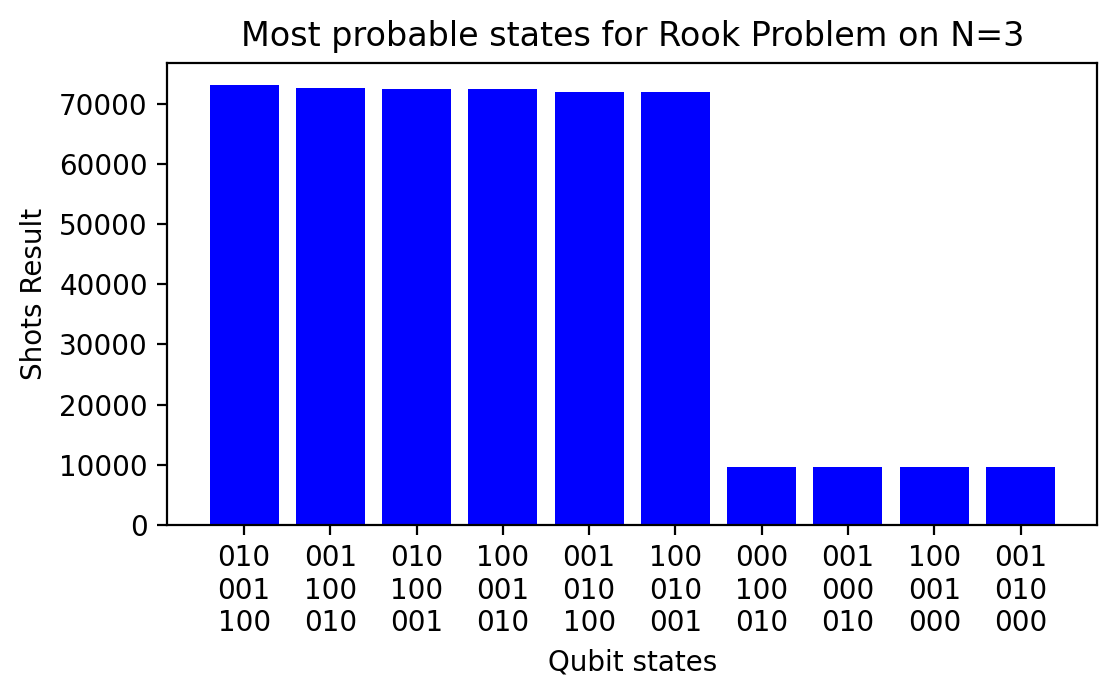

In [23]:
# 3x3 case
opt_circuit, res, init_params = QAOA_rooks(3)
process_results(3, opt_circuit)

Energía mínima encontrada: -3.029311181533564
Parámetros óptimos: [1.15177515 1.77431948 0.51798591 2.49101105]
Energía mínima encontrada: -2.834201010663433
Parámetros óptimos: [2.0963844  4.94227303 3.68832379 2.2634315 ]
Energía mínima encontrada: -2.8342010106633406
Parámetros óptimos: [1.0452083  1.34091227 4.68925663 1.92535864]
Energía mínima encontrada: -2.8923078321756304
Parámetros óptimos: [4.60415393 3.60305828 1.05540649 3.67828449]
Energía mínima encontrada: -3.3676842616616103
Parámetros óptimos: [3.62466869 3.39695721 3.77197286 2.98409941]
Energía mínima encontrada: -3.305410125190952
Parámetros óptimos: [0.29317261 2.90997774 3.75804363 5.48030595]
Energía mínima encontrada: -2.7298094745412906
Parámetros óptimos: [6.29897042 3.54394028 1.36905415 2.3756327 ]
Energía mínima encontrada: -3.029311181533654
Parámetros óptimos: [5.13141015 4.50886583 3.67080427 1.69777906]
Energía mínima encontrada: -3.2780431167405255
Parámetros óptimos: [4.3908911  4.48807847 4.55204707

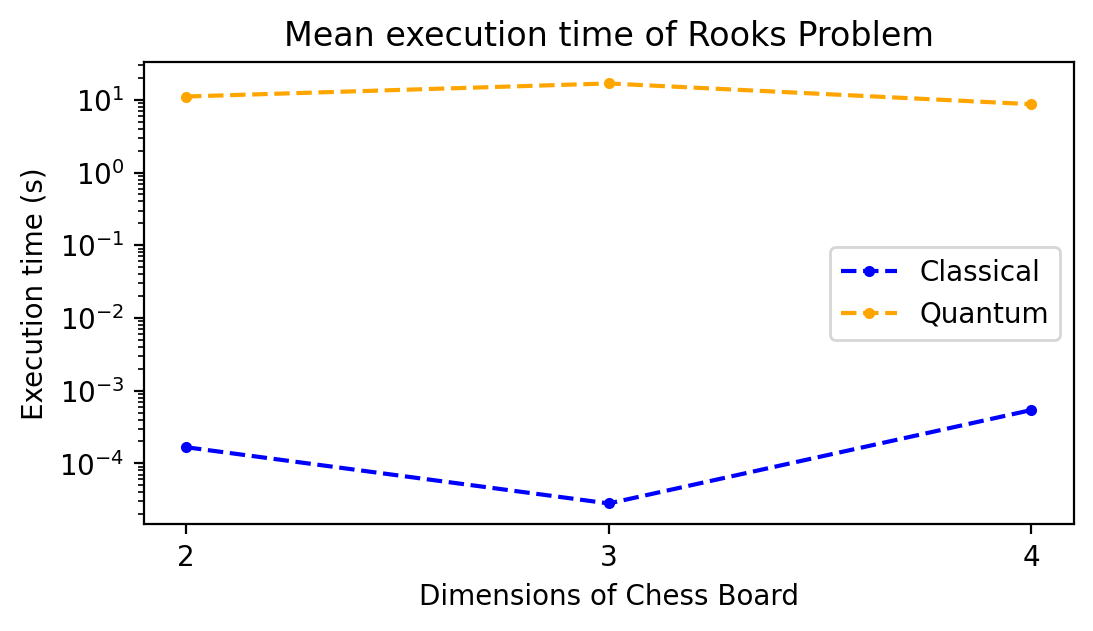

In [58]:
import time

N_list = [2, 3, 4]
t_classical, t_quantum = [], []
repeats = 10
for N in N_list:
    # Classical benchmark
    t_measure = 0
    for i in range(repeats):
        t_aux = time.time()
        classical_rooks(N)
        t_measure += time.time() - t_aux
    t_classical.append(t_measure/repeats)

    # Quantum benchmark
    t_measure = 0
    for i in range(repeats):
        t_aux = time.time()
        opt_circuit, final_params, init_params = QAOA_rooks(3)
        t_measure += time.time() - t_aux
    t_quantum.append(t_measure/repeats)

fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
ax.plot(N_list, t_classical, ls="--", label="Classical", color="blue", marker=".")
ax.plot(N_list, t_quantum, ls="--", label="Quantum", color="orange", marker=".")
plt.yscale('log')
ax.set_xlabel("Dimensions of Chess Board")
ax.set_ylabel("Execution time (s)")
ax.set_title("Mean execution time of Rooks Problem")
ax.set_xticks([2, 3, 4], labels=["2", "3", "4"])
ax.legend()
plt.show()

# 1.3 Improving the optimization

Now that everything is working properly, let's improve the QAOA protocol. Test the convergence of the solution and the parameters by changing different parameters of the algorithm.

Can you find a classical optimization algorithm that converges faster than the one by default on scipy.optimize? Does it change the result on the QAOA algorithm?

Does the convergence or the final solution improve using a different mixing operator?

How does the convergence and final solution change if we increase the number of layers from 2 to 3? How does the computation time change?

In [ ]:
# Test different possibilities here

# 2- Diagonal movement

As the queens can also move in diagonal, we will carefully analyze that movement playing the same game with bishops. (Be careful, this time for a board of NxN squares there are more than N possible bishops!!!!!!!!!!)

Repeat all previous steps with the bishops puzzle, to understand how can the diagonal movement be introduced in the hamiltonian. Fill all the following steps and comment everything you do to find the solution for 3x3 and 4x4 boards:

In [24]:
# Create the brute force function to find the solutions of the bishop puzzle
def max_bishops_solutions(N):
    sols = []
    max_count = 0  # Máximo número de alfiles encontrados

    def backtrack(pos, used_diag1, used_diag2, count, board):
        nonlocal max_count
        if pos == N * N:
            if count > max_count:
                max_count = count
                sols.clear()
                sols.append(np.copy(board))
            elif count == max_count:
                sols.append(np.copy(board))
            return

        row, col = divmod(pos, N)
        d1 = row + col
        d2 = row - col

        # Intentar colocar un alfil en esta casilla si las diagonales están libres
        if d1 not in used_diag1 and d2 not in used_diag2:
            board[row, col] = 1
            backtrack(pos + 1, used_diag1 | {d1}, used_diag2 | {d2}, count + 1, board)
            board[row, col] = 0

        # También podemos no poner alfil en esta casilla
        backtrack(pos + 1, used_diag1, used_diag2, count, board)

    initial_board = np.zeros((N, N), dtype=int)
    backtrack(0, set(), set(), 0, initial_board)

    return np.array(sols)

#Ejemplo de uso:
N = 3
sols = max_bishops_solutions(N)
print(f"Se encontraron {len(sols)} soluciones con el máximo número de alfiles en un tablero {N}x{N}.")
for s in sols:
    print(s)
    print()

Se encontraron 8 soluciones con el máximo número de alfiles en un tablero 3x3.
[[1 1 1]
 [0 0 0]
 [0 1 0]]

[[1 1 0]
 [0 0 0]
 [1 1 0]]

[[1 0 1]
 [1 0 1]
 [0 0 0]]

[[1 0 0]
 [1 0 1]
 [1 0 0]]

[[0 1 1]
 [0 0 0]
 [0 1 1]]

[[0 1 0]
 [0 0 0]
 [1 1 1]]

[[0 0 1]
 [1 0 1]
 [0 0 1]]

[[0 0 0]
 [1 0 1]
 [1 0 1]]



In [28]:
# One-body coefficients for the bishop Hamiltonian
def quantum_hamiltonian_bishop_onebody_coeff(N):
    """Returns the NxN matrix of b_{kα} weights."""
    # Each position has the same one-body weight
    b_vector = np.full((N, N), -1.5)
    return b_vector


# Two-body coefficients enforcing diagonal conflicts
def quantum_hamiltonian_bishop_twobody_coeff(N):
    """Returns the NxNxNxN array of Q_{kα, lβ} weights."""

    # Initialize 4D interaction matrix
    Q_matrix = np.full((N, N, N, N), 0.)

    # Assign weights between positions sharing a diagonal (major or minor)
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    # Bishops conflict if they share a diagonal
                    if ((k + alpha) == (l + beta) or (k - alpha) == (l - beta)) and not (
                        (k + alpha) == (l + beta) and (k - alpha) == (l - beta)
                    ):
                        Q_matrix[k, alpha, l, beta] = 1.5

    return Q_matrix

In [29]:
# Construct the cost Hamiltonian for the N-bishops problem with a tilt term
def cost_hamiltonian_bishop(N, delta):
    """Returns the Hamiltonian of the bishop puzzle as a SparsePauliOp.

    Args:
        N (int): The dimension of the chess board.
        delta (float): Strength of the tilting term, introducing position bias.

    Returns:
        hamiltonian (SparsePauliOp): The cost Hamiltonian of the bishop puzzle.
    """

    # --- Classical coefficients ---
    b_vector = quantum_hamiltonian_bishop_onebody_coeff(N)
    Q_matrix = quantum_hamiltonian_bishop_twobody_coeff(N)

    # Initialize Pauli operators for one- and two-body terms
    one_body = 0.
    two_body = 0.

    # Start from an identity string over all qubits (length N²)
    id_og = (N * N) * "I"

    # Helper function: replace position (i, j) in an N×N grid with 'Z'
    def pauli_string(N, i, j, string):
        s_list = list(string)
        s_list[i * N + j] = 'Z'
        return ''.join(s_list)

    # --- Build Hamiltonian terms ---
    for k in range(N):
        id = str(np.copy(id_og))
        for alpha in range(N):
            # One-body Pauli term at position (k, α)
            id_one_body = pauli_string(N, k, alpha, id)
            pauli_one_body = SparsePauliOp(id_one_body)

            # Add tilting contribution depending on row/column
            if k == 0:
                coeff = -0.5 * (b_vector[k, alpha] + np.sqrt(alpha) * delta)
            elif alpha == 0:
                coeff = -0.5 * (b_vector[k, alpha] + np.sqrt(k) * delta)
            else:
                coeff = -0.5 * (b_vector[k, alpha] + np.sqrt(alpha) * delta)

            one_body += coeff * pauli_one_body

            # Two-body terms: penalize configurations sharing diagonals
            for l in range(N):
                for beta in range(N):
                    id_other_index = pauli_string(N, l, beta, id)
                    id_two_body = pauli_string(N, l, beta, id_one_body)

                    # Build interaction operator using Pauli-Z combinations
                    pauli_final = SparsePauliOp.from_list([
                        (id_two_body, 1),
                        (id_other_index, -1),
                        (id_one_body, -1)
                    ])

                    # Add weighted contribution to the Hamiltonian
                    two_body += 0.5 * 0.25 * Q_matrix[k, alpha, l, beta] * pauli_final

    # Combine one-body and two-body contributions
    hamiltonian = two_body + one_body

    return hamiltonian

Energía mínima encontrada: -1.9738916098527908
Parámetros óptimos: [6.09953569 6.61071063 5.2405253  2.13127004]
Getting probs...
Readying probs for graph...
Making graph...


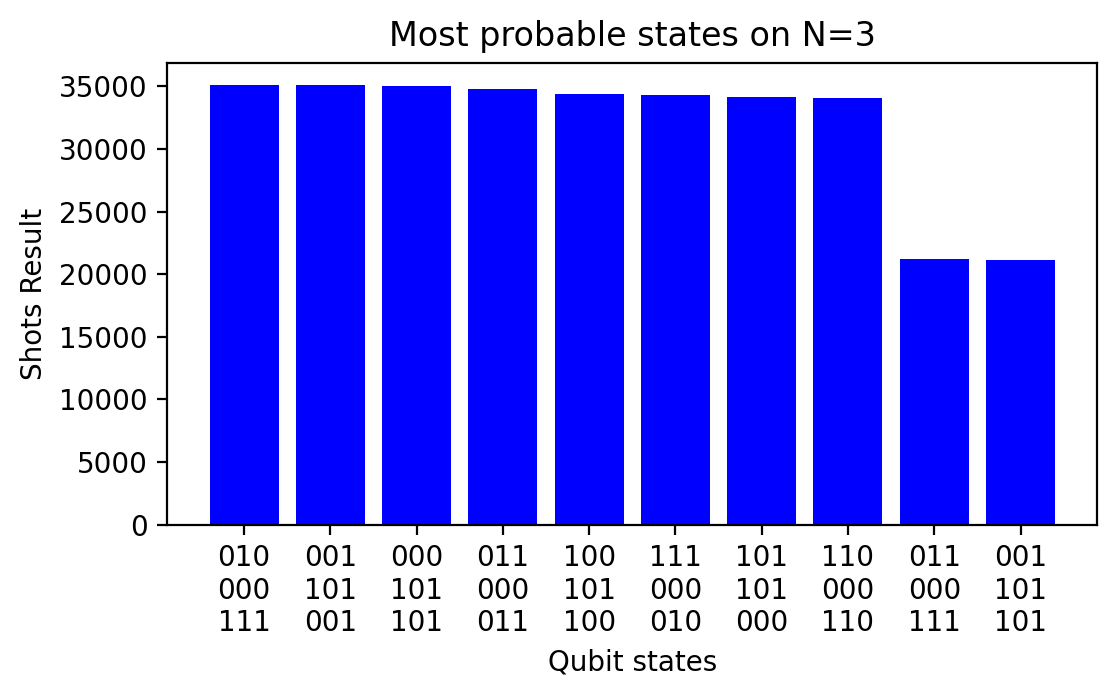

In [37]:
# Run QAOA for the bishop problem
def QAOA_bishop(N, delta, p=2):
    """Optimize the N-bishops problem using QAOA with tilt parameter delta."""

    # Build cost Hamiltonian with tilt
    H = cost_hamiltonian_bishop(N, delta)

    # Initialize estimator and pass manager
    estimator = Estimator()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

    # Build QAOA ansatz and apply layout
    var_state = pm.run(QAOAAnsatz(cost_operator=H, reps=p))
    isa_observable = H.apply_layout(var_state.layout)

    # Cost function: expectation value of Hamiltonian
    def cost_func_estimator(params, var_state, hamiltonian):
        job = estimator.run([(var_state, hamiltonian, params)])
        result = job.result()
        exp_val = result[0].data.evs
        return np.real(exp_val)

    # Random initialization of QAOA parameters
    init_params = np.random.uniform(0, 2*np.pi, 4)

    # Classical optimization using COBYLA
    res = minimize(
        cost_func_estimator,
        init_params,
        args=(var_state, H),
        method="COBYLA",
        tol=1e-8,
    )

    # Report results
    print("Energía mínima encontrada:", res.fun)
    print("Parámetros óptimos:", res.x)

    # Construct optimized circuit
    opt_circuit = var_state.assign_parameters(res.x)
    return opt_circuit, res.x, init_params


# Measure the optimized circuit and plot results
def process_results(N, opt_circuit, n_bars=10, n_probs=500, n_shots=1e6):
    """Measure the optimized QAOA circuit and plot the most probable states."""

    sampler = SamplerV2()

    print("Getting probs...")
    opt_circuit.measure_all()

    # Execute the circuit
    pub = (opt_circuit,)
    job = sampler.run([pub], shots=int(n_shots))
    result = job.result()[0]
    counts_bin = result.data.meas.get_counts()

    # Prepare top measurement outcomes
    ord_labs, ord_res = [], []
    print("Readying probs for graph...")
    for bitstring, p in sorted(counts_bin.items(), key=lambda x: -x[1])[:n_probs]:
        n_bitstring = [bitstring[N*i:N*(i+1)] + "\n" for i in range(N)]
        ord_labs.append("".join(n_bitstring)[:-1])
        ord_res.append(p)

    # Plot most probable bitstrings
    print("Making graph...")
    fig, ax = plt.subplots(dpi=200, figsize=(6, 3))
    ax.bar(ord_labs[:n_bars], ord_res[:n_bars], color="blue")
    ax.set_ylabel("Shots Result")
    ax.set_xlabel("Qubit states")
    ax.set_title(f"Most probable states on N={N}")
    plt.show()
    return


# Example: 3x3 bishop puzzle
opt_circuit, res, init_params = QAOA_bishop(3, delta=0.005)
process_results(3, opt_circuit)

# 3- The queens puzzle

Now that we have analyzed both movements of the queens, we can put everything together and find a solution for the queens problem. For that, you only need to combine the two body interactions of the rooks with those of the bishops and voila! The queens cost hamiltonian is done!

Repeat again the previous steps to find the solution for the queens puzzle for 3x3 and 4x4 boards. You can jump some steps if you find them unnecessary, but at the end you should compare the brute force solutions with those obtained by QAOA

In [27]:
def max_queens_solutions(N):
    """Find all arrangements of queens that maximize non-attacking placement on an N×N board."""

    sols = []          # List to store solutions
    max_count = 0      # Track the maximum number of queens placed

    def backtrack(row, used_cols, used_diag1, used_diag2, count, board):
        """Recursive backtracking function."""

        nonlocal max_count

        # Base case: reached the end of the board
        if row == N:
            if count > max_count:
                max_count = count
                sols.clear()
                sols.append(np.copy(board))
            elif count == max_count:
                sols.append(np.copy(board))
            return

        # Try placing a queen in each column of this row
        for col in range(N):
            d1 = row + col       # Major diagonal
            d2 = row - col       # Minor diagonal
            if col not in used_cols and d1 not in used_diag1 and d2 not in used_diag2:
                board[row, col] = 1
                backtrack(
                    row + 1,
                    used_cols | {col},
                    used_diag1 | {d1},
                    used_diag2 | {d2},
                    count + 1,
                    board
                )
                board[row, col] = 0  # Backtrack

        # Also allow skipping this row (not placing a queen)
        backtrack(row + 1, used_cols, used_diag1, used_diag2, count, board)

    # Initialize empty board
    initial_board = np.zeros((N, N), dtype=int)
    backtrack(0, set(), set(), set(), 0, initial_board)

    return np.array(sols), max_count


# --- Example usage ---
N = 3
sols, max_q = max_queens_solutions(N)
print(f"Maximum queens that can be placed on a {N}x{N} board: {max_q}")
print(f"Number of maximum-queen solutions: {len(sols)}")
for s in sols:
    print(s)
    print()

Maximum queens that can be placed on a 3x3 board: 2
Number of maximum-queen solutions: 8
[[1 0 0]
 [0 0 1]
 [0 0 0]]

[[1 0 0]
 [0 0 0]
 [0 1 0]]

[[0 1 0]
 [0 0 0]
 [1 0 0]]

[[0 1 0]
 [0 0 0]
 [0 0 1]]

[[0 0 1]
 [1 0 0]
 [0 0 0]]

[[0 0 1]
 [0 0 0]
 [0 1 0]]

[[0 0 0]
 [1 0 0]
 [0 0 1]]

[[0 0 0]
 [0 0 1]
 [1 0 0]]



In [67]:
# One-body coefficients: same weight for each square
def quantum_hamiltonian_queens_onebody_coeff(N: int) -> np.ndarray:
    b_vector = np.full((N, N), -1.0)
    return b_vector


# Two-body coefficients: penalize row, column, and diagonal conflicts
def quantum_hamiltonian_queens_twobody_coeff(N: int) -> np.ndarray:
    Q_matrix = np.full((N, N, N, N), 0.)
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    cond_diag = ((k + alpha) == (l + beta) or (k - alpha) == (l - beta)) \
                                and not ((k + alpha) == (l + beta) and (k - alpha) == (l - beta))
                    cond_rook = ((k == l) or (alpha == beta)) and not (k == l and alpha == beta)
                    if cond_diag or cond_rook:
                        Q_matrix[k, alpha, l, beta] = 1.5
    return Q_matrix


# Build the Hamiltonian as a SparsePauliOp
def cost_hamiltonian_queens(N):
    b_vector = quantum_hamiltonian_queens_onebody_coeff(N)
    Q_matrix = quantum_hamiltonian_queens_twobody_coeff(N)

    one_body = 0.
    two_body = 0.
    id_og = (N * N) * "I"

    def pauli_string(N, i, j, string):
        s_list = list(string)
        s_list[i * N + j] = 'Z'
        return ''.join(s_list)

    for k in range(N):
        id = str(np.copy(id_og))
        for alpha in range(N):
            # One-body Pauli-Z term
            id_one_body = pauli_string(N, k, alpha, id)
            pauli_one_body = SparsePauliOp(id_one_body)
            one_body += -0.5 * b_vector[k, alpha] * pauli_one_body

            # Two-body Pauli-Z interactions
            for l in range(N):
                for beta in range(N):
                    id_other_index = pauli_string(N, l, beta, id)
                    id_two_body = pauli_string(N, l, beta, id_one_body)
                    pauli_final = SparsePauliOp.from_list([
                        (id_two_body, 1),
                        (id_other_index, -1),
                        (id_one_body, -1)
                    ])
                    two_body += 0.5 * 0.25 * Q_matrix[k, alpha, l, beta] * pauli_final

    hamiltonian = two_body + one_body
    return hamiltonian


# Run QAOA for N-Queens
def QAOA_queens(N, p=2):
    H = cost_hamiltonian_queens(N)
    estimator = Estimator()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

    var_state = pm.run(QAOAAnsatz(cost_operator=H, reps=p))
    isa_observable = H.apply_layout(var_state.layout)

    # Expectation value function for optimization
    def cost_func_estimator(params, var_state, hamiltonian):
        job = estimator.run([(var_state, hamiltonian, params)])
        result = job.result()
        exp_val = result[0].data.evs
        return np.real(exp_val)

    # Random initial parameters
    init_params = np.random.uniform(0, 2 * np.pi, p * 2)

    # Classical optimization
    res = minimize(
        cost_func_estimator,
        init_params,
        args=(var_state, H),
        method="COBYLA",
        tol=1e-8
    )

    # Report results
    print("Energía mínima encontrada:", res.fun)
    print("Parámetros óptimos:", res.x)
    opt_circuit = var_state.assign_parameters(res.x)
    return opt_circuit, res.x, init_params

Energía mínima encontrada: -5.1358907159319225
Parámetros óptimos: [0.40351792 3.02401384 4.66764242 1.38014666]
Getting probs...
Readying probs for graph...
Making graph...


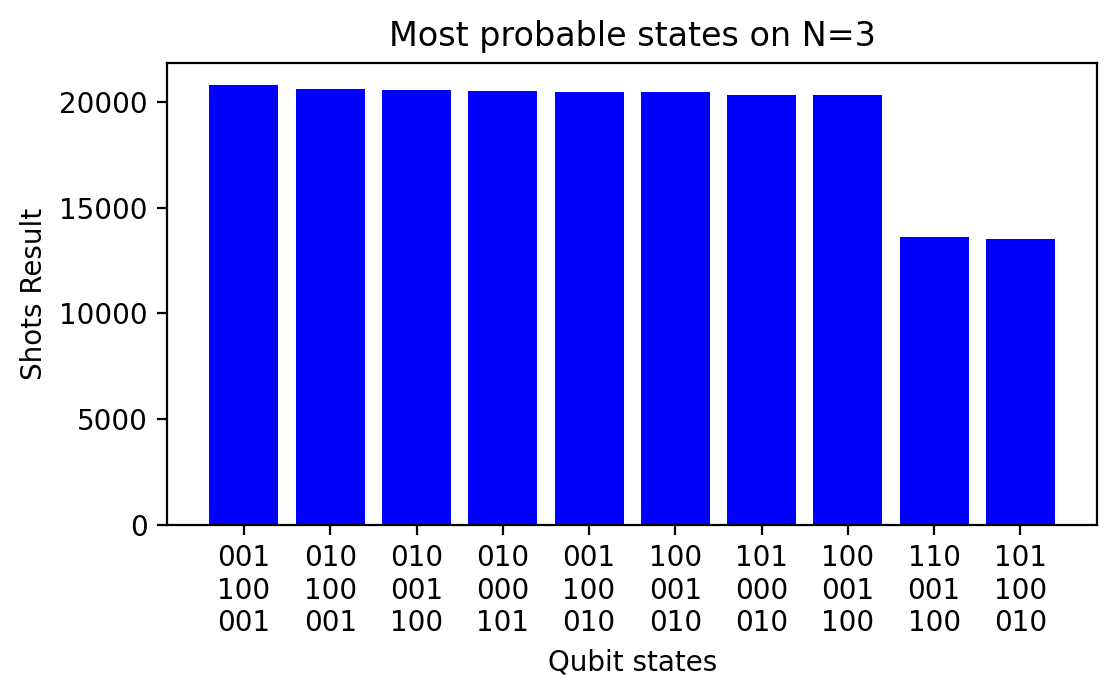

In [68]:
opt_circuit = QAOA_queens(3, p=2)[0]
process_results(3, opt_circuit)

For one of the iterations we got the following results

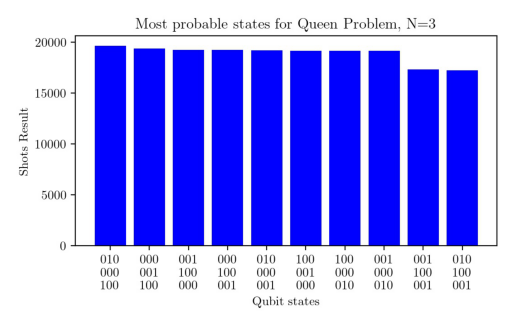

In [63]:
import matplotlib.image as mpimg

# Cargar imagen
img = mpimg.imread("Queens.jpeg")

# Mostrarla
plt.imshow(img)
plt.axis("off")
plt.show()

# 4- Going to utility-scale problems

Now that you have solved small instances of the queens puzzle you might think, what's next?? Prepare for the most difficult and exciting part of the challenge!!

The previous sections where only restricted to 3x3 and 4x4 boards because bigger circuits are much expensive to simulate using classical computers and will take a lot of time to do the optimization. Then, you might think, Is this worthy?
Yes, it is. If we run it on a quantum computer!!
Try to run 5x5 and 6x6 boards on it!.

Go again to [IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) and try to run a bigger board instance in real quantum hardware.
For that you will need to register on ibm and you will have a maximum of 10 minutes of Q-computations, so be cautious. Plan everything before running it and save every result obtained to present it in the final report.

In [ ]:
# Your code here

# 5- A farm of horses

The queens and rooks and bishops move in lines, but what about horses?

Explore the possible configurations solutions for the horses puzzle for small boards. Is this problem as easy to converge than the other instances? Which is the biggest difference?

In [ ]:
# Your code here

# 6- A parallel story  (Truly challenging - research level)

Read the following works about the queens puzzle and compare what they propose with the things that we have done here:

- https://arxiv.org/html/2312.16312v1
- https://quantum-journal.org/papers/q-2019-06-03-149/

Based on those articles, which changes should be done to improve the resolution of the problem? Do you think that this will make a substantial change on your outcomes?

Can you improve the solution of the problem? Maybe propose a new mapping? Maybe use a different algorithm?

Open solution question, let your imagination running!

In [ ]:
# Your code here